In [1]:
import glam
import pandas as pd
import numpy as np
import os.path
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
import pymc3 as pm

In [59]:

from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation


In [3]:
np.random.seed(23) # from random.org

In [4]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [70]:
def ttestsPlot(data1, data2,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "Like", lab2 = "Dislike",title = ''):

    # t-TEST
    diff = np.mean(data1) - np.mean(data2)
    [s, p] = stats.ttest_ind(data1,data2)
    print ("ChoiceSlopes: MeanL = "+ str(np.mean(data1))+ "; MeanD = "+ str(np.mean(data2))+"; [Like - Dislike] =  " + str(diff) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(p) )
    
        
    # PLOT LIKE AND DISLIKE VARIABILITY
        
    # Set seaborn style for the plot
    fig = plt.figure(figsize=[6,10])
    sns.set(style='white',font_scale=1.5)
    jittr1 = np.random.uniform(low=-0.3,high=0.3,size=len(data1))   
    jittr2 = np.random.uniform(low=-0.3,high=0.3,size=len(data2))   

    plt.scatter([1]*len(data1)+jittr1, data1, c= c1, alpha=0.7,label=lab1)
    plt.scatter([2]*len(data2)+jittr2, data2, c= c2, alpha=0.7,label=lab2)
    
    ## add lines between slope points in like and dislike for each participant
    
   ## for i in range(len(data1)):
   ##     plt.plot( [1 + jittr[i],2 + jittr[i]], [ data1[i] , data2[i]],'--', lw=1.0, color = 'black', alpha = 0.2)
   ##     if data1[i]<data2[i]:
    ##        print ("Participants with slope in Like < Dislike: " + str(i))
            
    
    #legend(loc = 'best')
    plt.xticks([1, 2], [lab1, lab2],fontsize=25)
    plt.yticks(fontsize=20)
    
    plt.ylabel(title, fontsize=28)
    sns.despine()

# Individual GLAM estimation and out of sample prediction

## Load data

In [122]:
# Load data
sufix = '_individual_More_NoBin_excludedTrial_Gamma-11_NUTS_32'
data = pd.read_csv('data/PF2019_data/GlamDataPF2019_More_NoBin_33_v2.csv')

## Reaction times for each participant

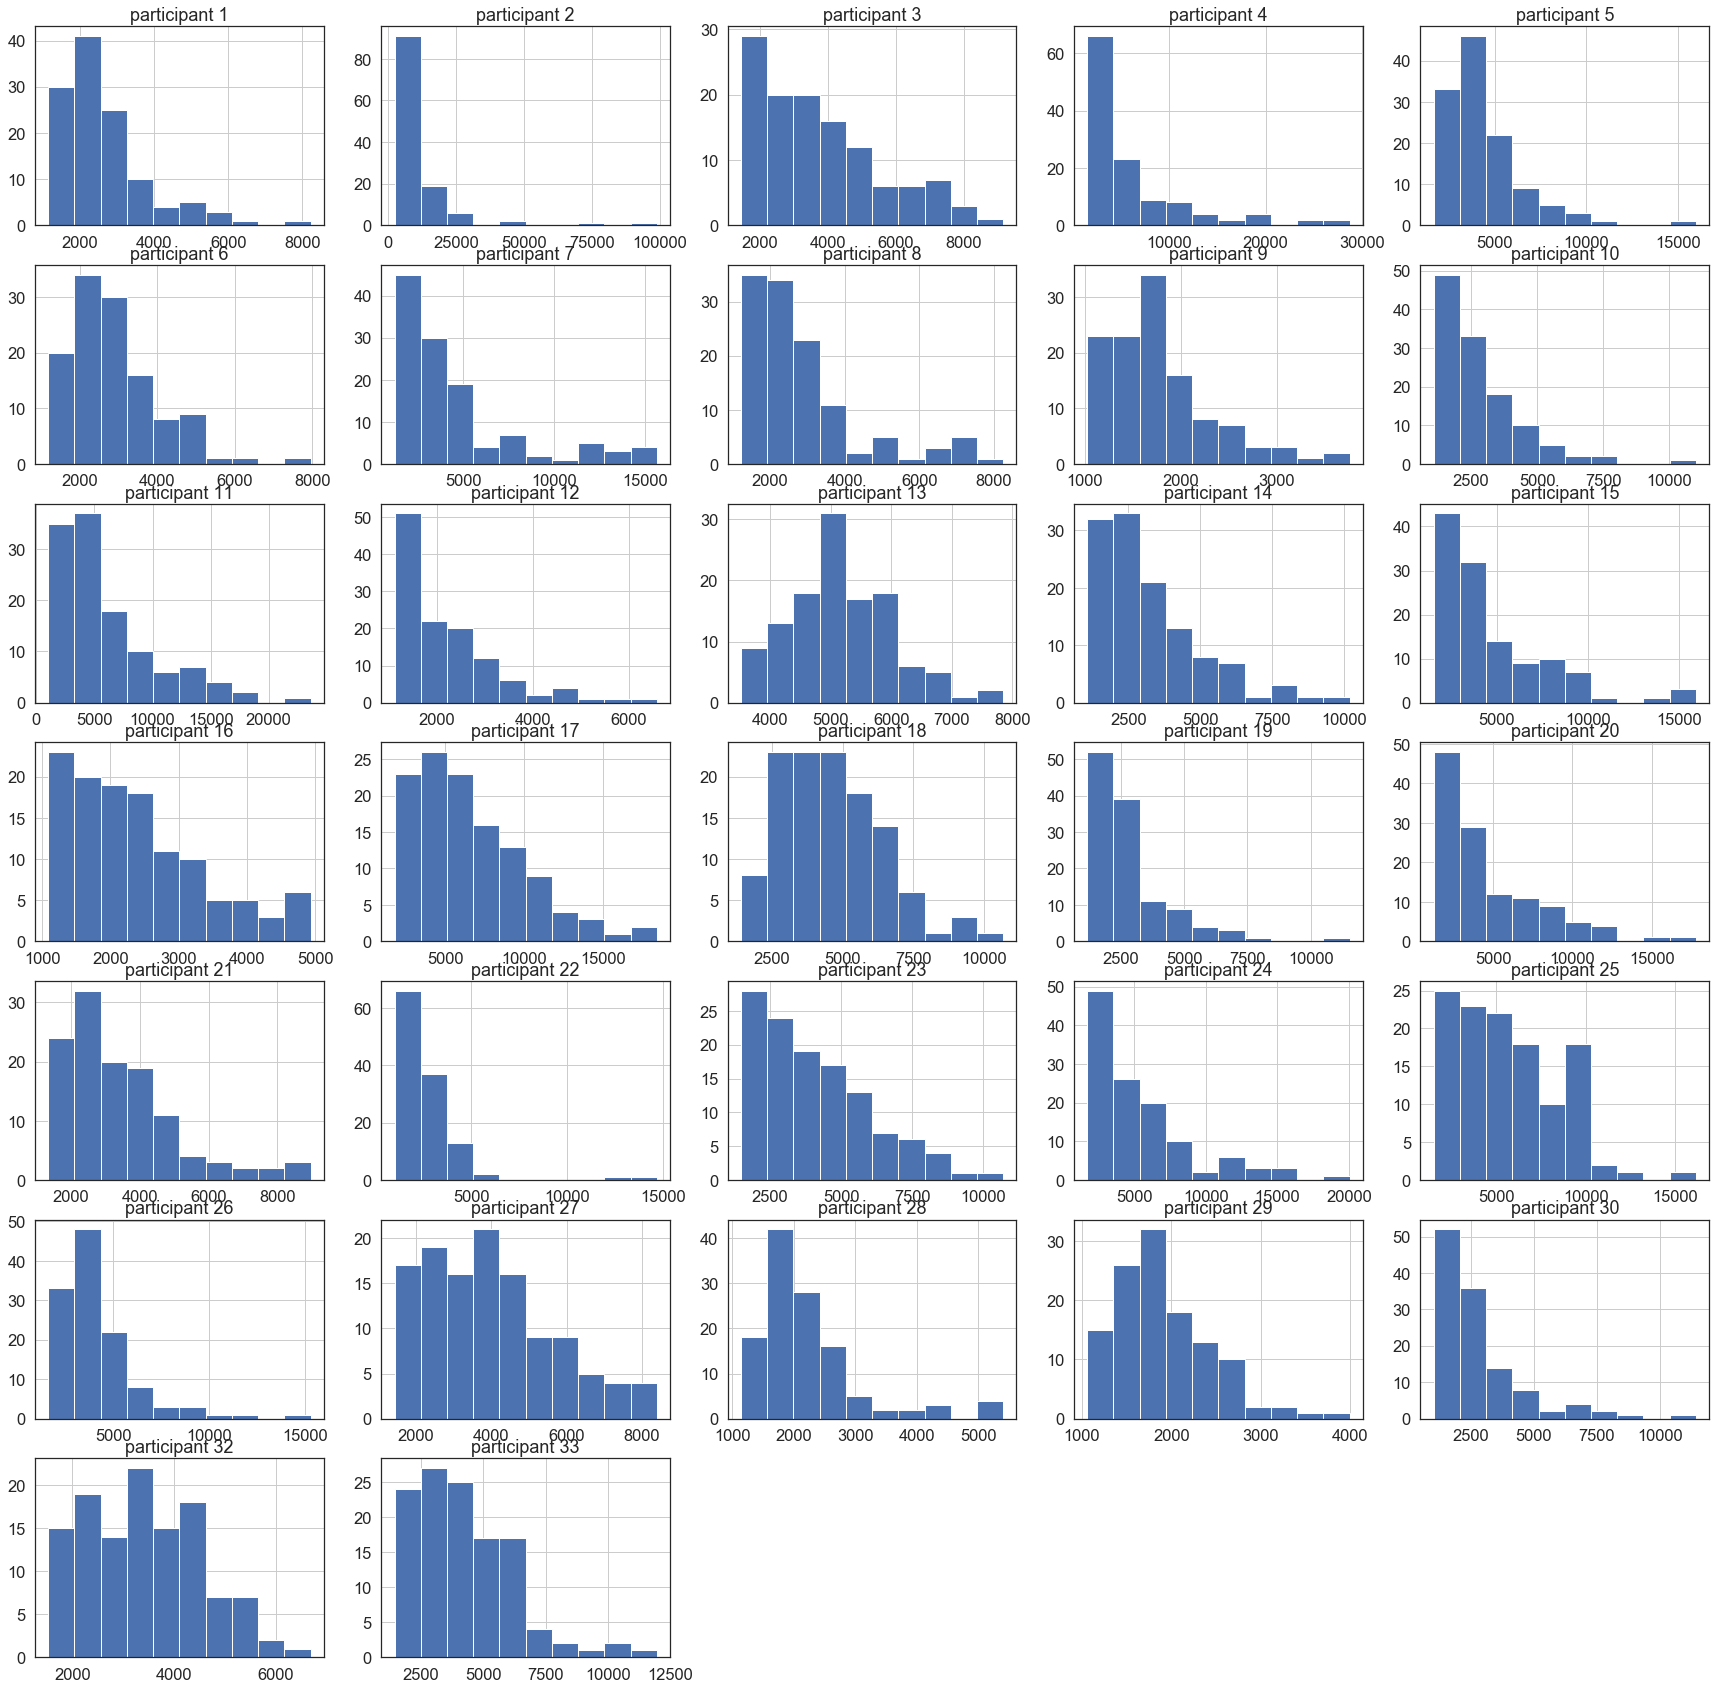

In [123]:
participants = data.subject.unique()
f = plt.figure(figsize=(30,30))
order = 1
sns.set_style('white')

for i in data.subject.unique():
    sub={}
    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
    sub['%s' % i].plot()    
    data[(data.subject == i)].rt.hist()
    sub['%s' % i].set_title('participant %s' % i)
    order += 1


In [124]:
data["zrt"] = z_score1(data,'subject',"rt")

## Remove outliers

In [125]:
# remove outliers (two criteria)
data1 = data[(data.zrt <= 3) ]
data1 = data1[(data1.rt <= 20000) ]

In [126]:
#participants = data.subject.unique()
#f = plt.figure(figsize=(30,30))
#order = 1
#sns.set_style('white')

#for i in data.subject.unique():
#    sub={}
#    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
#    sub['%s' % i].plot()    
#    data[(data.subject == i)].zrt.hist()
#    sub['%s' % i].set_title('participant %s' % i)
#    order += 1

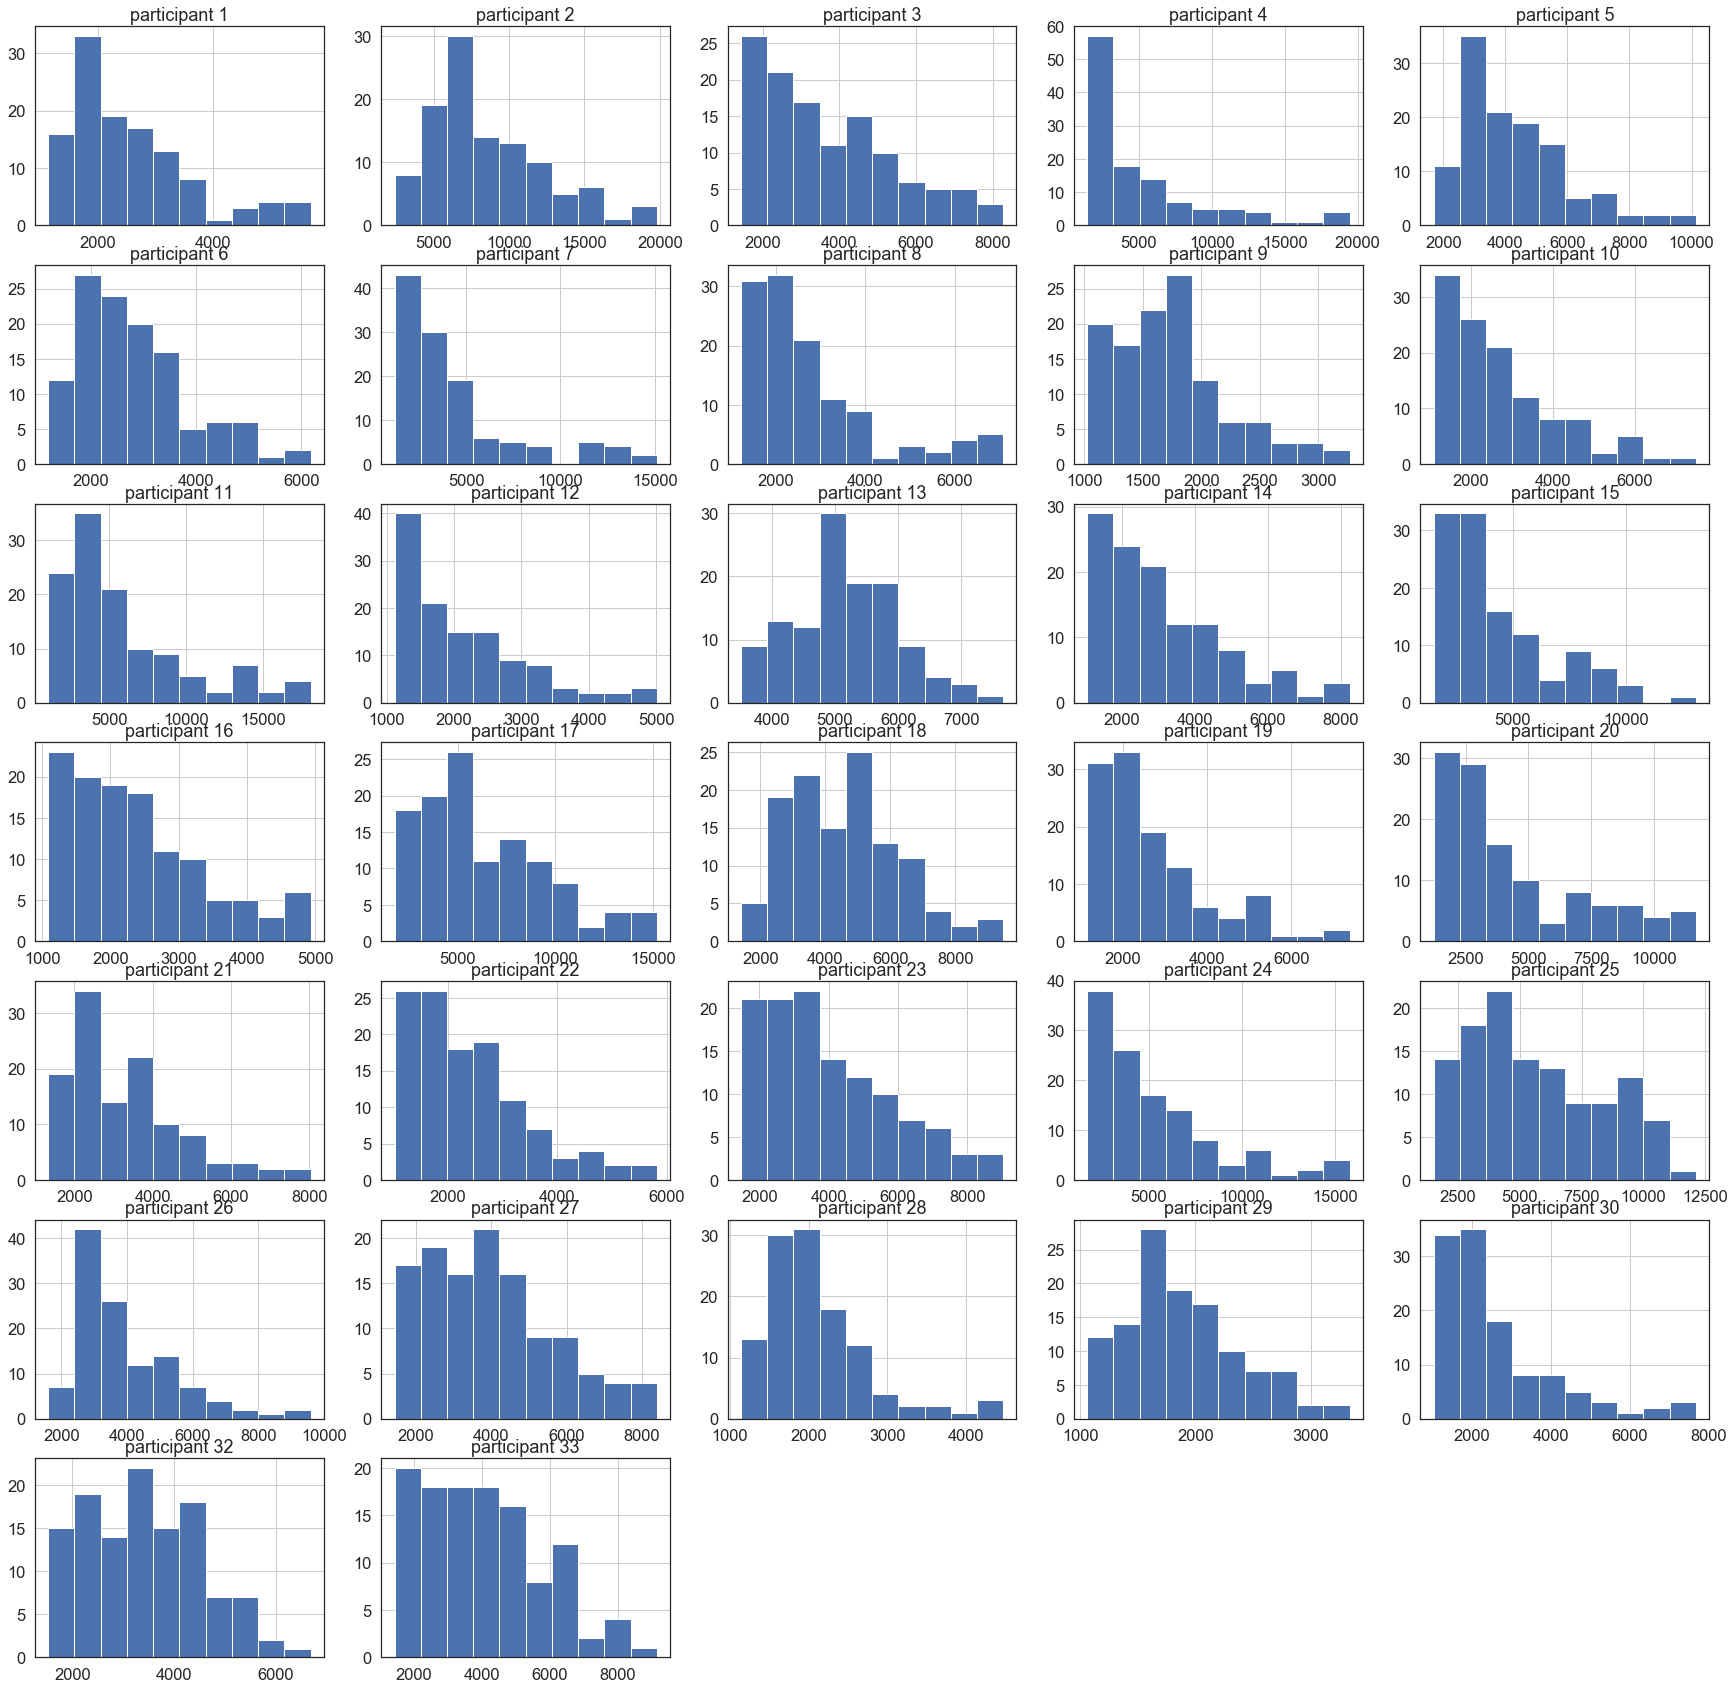

In [127]:
participants = data1.subject.unique()
f = plt.figure(figsize=(30,30))
order = 1
sns.set_style('white')

for i in data1.subject.unique():
    sub={}
    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
    sub['%s' % i].plot()    
    data1[(data1.subject == i)].rt.hist()
    sub['%s' % i].set_title('participant %s' % i)
    order += 1

# Subset only necessary columns

In [13]:
data = data1[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,1,0,1,1734.284,110,131,0.669090,0.330910
2,1,2,0,3174.566,50,44,0.549371,0.450629
3,1,3,1,2877.579,57,50,0.608409,0.391591
4,1,4,1,1806.310,42,50,0.522849,0.477151
5,1,5,0,3636.816,108,110,0.559774,0.440226


## Select only conflictive participants

In [14]:
data = data[ (data['subject'] == 1) | (data['subject'] == 13) | (data['subject'] == 16) | (data['subject'] == 20)]

In [17]:
data.subject.unique()

array([ 1, 13, 16, 20])

## Extract some Non conflictive participants

In [99]:
data_nonConflictive = data[ (data['subject'] == 2) ]

In [100]:
data_nonConflictive.subject.unique()

array([2])

## Split data in training and test sets

In [19]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

#test_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_test'+sufix+'.csv'))
#train_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (238 trials) and test (237 trials) sets...


## Individual GLAM estimation

### 1. full GLAM

In [128]:
data1

,Unnamed: 0,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,RT,zrt
0,0,1,0,1734.284,1,110,131,0.669090,0.330910,1734.284,-0.750411
2,2,1,2,3174.566,0,50,44,0.549371,0.450629,3174.566,0.435809
3,3,1,3,2877.579,1,57,50,0.608409,0.391591,2877.579,0.191210
4,4,1,4,1806.310,1,42,50,0.522849,0.477151,1806.310,-0.691090
5,5,1,5,3636.816,0,108,110,0.559774,0.440226,3636.816,0.816520
6,6,1,6,3650.266,1,78,80,0.682034,0.317966,3650.266,0.827597
7,7,1,7,3078.223,0,110,92,0.565221,0.434779,3078.223,0.356461
8,8,1,8,1259.268,1,50,48,0.508019,0.491981,1259.268,-1.141635
9,9,1,9,3440.738,0,110,101,0.558373,0.441627,3440.738,0.655029
10,10,1,10,5698.027,1,46,50,0.582089,0.417911,5698.027,2.514139


In [24]:
# Fitting full GLAM
print('Fitting full GLAM individually...')

glam_full = glam.GLAM(train_data)

glam_full.make_model('individual', gamma_bounds=(-1, 1), t0_val=0)
glam_full.fit(method='NUTS', tune=1000)


Fitting full GLAM individually...
Generating single subject models for 4 subjects...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 4 model(s) using NUTS...
  Fitting model 1 of 4...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:07<00:00, 1695.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 2 of 4...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1107.62draws/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 3 of 4...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:22<00:00, 526.17draws/s]
There were 414 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4733932007356967, but should be close to 0.8. Try to increase the number of tuning steps.
There were 250 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4927882511309006, but should be close to 0.8. Try to increase the number of tuning steps.
There were 418 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5567887986252144, but should be close to 0.8. Try to increase the number of tuning steps.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 

  Fitting model 4 of 4...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:13<00:00, 863.66draws/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.659686272713003, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/!\ Automatically setting parameter precision...


In [25]:
glam_full.estimates

[{'b': 1.0,
  'p_error': 0.05,
  'v': 4.1e-05,
  'gamma': 0.8,
  'SNR': 198.29,
  's': 0.009338,
  'tau': 1.8,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 1.9e-05,
  'gamma': 0.99,
  'SNR': 101.55,
  's': 0.001985,
  'tau': 4.76,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 4.6e-05,
  'gamma': 0.59,
  'SNR': 149.29,
  's': 0.007569,
  'tau': 4.99,
  't0': array([0.])},
 {'b': 1.0,
  'p_error': 0.05,
  'v': 2.8e-05,
  'gamma': 0.58,
  'SNR': 292.79,
  's': 0.010273,
  'tau': 4.09,
  't0': array([0.])}]

In [55]:
pd.DataFrame.from_dict(glam_full.estimates)

,SNR,b,gamma,p_error,s,t0,tau,v
0,198.29,1.0,0.80,0.05,0.009338,[0.0],1.80,0.000041
1,101.55,1.0,0.99,0.05,0.001985,[0.0],4.76,0.000019
2,149.29,1.0,0.59,0.05,0.007569,[0.0],4.99,0.000046
3,292.79,1.0,0.58,0.05,0.010273,[0.0],4.09,0.000028


In [57]:
params_like_eliminated = pd.DataFrame.from_dict(glam_full.estimates)
params_like_eliminated

,SNR,b,gamma,p_error,s,t0,tau,v
0,198.29,1.0,0.80,0.05,0.009338,[0.0],1.80,0.000041
1,101.55,1.0,0.99,0.05,0.001985,[0.0],4.76,0.000019
2,149.29,1.0,0.59,0.05,0.007569,[0.0],4.99,0.000046
3,292.79,1.0,0.58,0.05,0.010273,[0.0],4.09,0.000028


In [82]:
# Predictions
glam_full.exchange_data(test_data)

glam_full.predict(n_repeats=50)
glam_full.prediction.to_csv(str('results/predictions/glam_PF2019_full_'+sufix+'_TEST_CONFLICTIVE.csv'), index=False)
glam_full.prediction.head()

Replaced attached data (76 trials) with new data (237 trials)...


,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
0,1.0,0.0,0.0,0.0,3060.0,50,0.549371,44,0.450629
1,1.0,0.0,1.0,0.0,937.0,50,0.549371,44,0.450629
2,1.0,0.0,2.0,0.0,2050.0,50,0.549371,44,0.450629
3,1.0,0.0,3.0,0.0,3913.0,50,0.549371,44,0.450629
4,1.0,0.0,4.0,0.0,2486.0,50,0.549371,44,0.450629


In [90]:
glam_full.prediction[glam_full.prediction['rt'] < -0].subject.unique()

array([ 1., 13., 16., 20.])

In [94]:
np.sort(glam_full.prediction[glam_full.prediction['rt'] < -0].trial.unique())

array([ 0.,  1.,  4.,  5., 10., 11., 13., 17., 20., 24., 26., 28., 29.,
       31., 32., 33., 34., 36., 38., 39., 41., 42., 43., 44., 46., 48.,
       51., 54., 55.])

## Repeat simulation using Non-conflictive participant trials

In [104]:
data_nonConflictive.subject.unique()

array([2])

In [105]:
# Predictions
glam_full.exchange_data(data_nonConflictive)

glam_full.predict(n_repeats=50)
glam_full.prediction.to_csv(str('results/predictions/glam_PF2019_full_'+sufix+'_TEST_CONFLICTIVE_NON_CONFL_PARTICIPANT.csv'), index=False)
glam_full.prediction.head()

Replaced attached data (237 trials) with new data (120 trials)...


,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
0,2.0,0.0,0.0,0.0,0.0,110,0.575607,131,0.424393
1,2.0,0.0,1.0,0.0,0.0,110,0.575607,131,0.424393
2,2.0,0.0,2.0,0.0,0.0,110,0.575607,131,0.424393
3,2.0,0.0,3.0,0.0,0.0,110,0.575607,131,0.424393
4,2.0,0.0,4.0,0.0,0.0,110,0.575607,131,0.424393


In [106]:
glam_full.prediction[glam_full.prediction['rt'] < -0]

,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
10,2.0,0.0,10.0,0.0,-1.568810e+10,110,0.575607,131,0.424393
43,2.0,0.0,43.0,0.0,-6.275238e+10,110,0.575607,131,0.424393
259,2.0,5.0,9.0,0.0,-3.542144e+13,108,0.119482,110,0.880518
484,2.0,9.0,34.0,1.0,-2.179341e+23,110,0.912837,101,0.087163
764,2.0,15.0,14.0,1.0,-1.282459e+20,91,0.835951,80,0.164049
776,2.0,15.0,26.0,1.0,-1.282459e+20,91,0.835951,80,0.164049
777,2.0,15.0,27.0,1.0,-1.282459e+20,91,0.835951,80,0.164049
779,2.0,15.0,29.0,1.0,-1.282459e+20,91,0.835951,80,0.164049
791,2.0,15.0,41.0,1.0,-1.282459e+20,91,0.835951,80,0.164049
794,2.0,15.0,44.0,1.0,-1.282459e+20,91,0.835951,80,0.164049


#### * Even if we use trials from other participants, the problem remains. The trial combination is the problem

## Repeat simulations only for conflictive combinations of gaze and item_value

In [78]:
conflictive_trials = glam_full.prediction[glam_full.prediction['rt'] < -0]

In [79]:
# Predictions
glam_full.exchange_data(conflictive_trials)

glam_full.predict(n_repeats=50)
glam_full.prediction.to_csv(str('results/predictions/glam_PF2019_full_'+sufix+'_TEST_CONFLICTIVE_TRIALS.csv'), index=False)
glam_full.prediction.head()

Replaced attached data (237 trials) with new data (76 trials)...


,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
0,1.0,0.0,0.0,1.0,0.0,131,0.577821,110,0.422179
1,1.0,0.0,1.0,0.0,1961.0,131,0.577821,110,0.422179
2,1.0,0.0,2.0,0.0,2124.0,131,0.577821,110,0.422179
3,1.0,0.0,3.0,1.0,0.0,131,0.577821,110,0.422179
4,1.0,0.0,4.0,0.0,4337.0,131,0.577821,110,0.422179


In [ ]:
def balance_evidence(value_tests, gaze_tests, parameters,boundary, error_weight, error_range,n_repeats):
    
    mean_rts_trials = np.zeros((value_tests.shape[0])) * np.nan
    choice_trials = np.zeros((value_tests.shape[0])) * np.nan
    DEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    AbsDEv_trials = np.zeros((value_tests.shape[0])) * np.nan
    Ev_drifts_0_trials  = []
    Ev_drifts_1_trials = []

    n_trials, n_items = value_tests.shape

    running_idx_value = 0
    #we iterate for all the combinations of trials + gaze
    for trial in range(n_trials):
        
            # intialize the drifts
            evidence_drifts_0 = []
            evidence_drifts_1 = []

            #define value and gaze values for this particular trial
            value_trial =value_tests[trial]
            gaze_trial =gaze_tests[trial]
            
            Sim_value = value_trial
            Sim_gaze = gaze_trial
            
            Delta_E = np.zeros(n_repeats) * np.nan            
            AbsDelta_E = np.zeros(n_repeats) * np.nan
            rts = np.zeros(n_repeats) * np.nan
            choices = np.zeros(n_repeats) * np.nan
            trial_idx = np.zeros(n_repeats) * np.nan
            repeat_idx = np.zeros(n_repeats) * np.nan
            running_idx = 0
        
            for repeat in range(n_repeats):
                    

                    
                    Evi_0, Evi_1, choice, rt = glam.driftSim.simulate_trial_drift(parameters, value_trial, gaze_trial,
                                                boundary=boundary,
                                                error_weight=error_weight,
                                                error_range=error_range)
                    
                    Delta_E[running_idx] = Evi_1[-1] - Evi_0[-1]
                    AbsDelta_E[running_idx] = abs(Evi_0[-1] - Evi_1[-1])                        
                    rts[running_idx] = rt
                    choices[running_idx] = choice
                    trial_idx[running_idx] = trial
                    repeat_idx[running_idx] = repeat
                    # Add a new sequence of drift for this particular trial
                    evidence_drifts_0.append(Evi_0)
                    evidence_drifts_1.append(Evi_1)
                    
                    running_idx += 1
                    
               
            # Add the mean value for this parameters interation               
            mean_rts_trials [running_idx_value] = rts.mean()
            choice_trials [running_idx_value]= choices.mean() 
            DEv_trials [running_idx_value] = Delta_E.mean()
            AbsDEv_trials [running_idx_value]= AbsDelta_E.mean()
            Ev_drifts_0_trials.append(evidence_drifts_0)
            Ev_drifts_1_trials.append(evidence_drifts_1)
 
            running_idx_value += 1 

    return AbsDEv_trials,mean_rts_trials,Ev_drifts_0_trials,Ev_drifts_1_trials,choice_trials

## negative RT appear again in the simulations of these participants

In [33]:
glam_full.prediction[glam_full.prediction['rt'] < -0]

,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1
658,1.0,13.0,8.0,1.0,-1.242160e+21,131,0.577821,110,0.422179
695,1.0,13.0,45.0,1.0,-4.140532e+20,131,0.577821,110,0.422179
720,1.0,14.0,20.0,0.0,-2.753731e+10,110,0.597667,133,0.402333
916,1.0,18.0,16.0,0.0,-4.294978e+06,92,0.578988,110,0.421012
943,1.0,18.0,43.0,0.0,-2.147489e+06,92,0.578988,110,0.421012
1158,1.0,23.0,8.0,1.0,-5.873200e+04,59,0.651123,50,0.348877
1554,1.0,31.0,4.0,1.0,-3.783305e+20,94,0.769843,80,0.230157
1565,1.0,31.0,15.0,1.0,-3.783305e+20,94,0.769843,80,0.230157
1576,1.0,31.0,26.0,1.0,-1.261102e+20,94,0.769843,80,0.230157
1580,1.0,31.0,30.0,1.0,-3.783305e+20,94,0.769843,80,0.230157


In [81]:
glam_full.prediction[glam_full.prediction['rt'] < -0].trial.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26.])

In [35]:
## all the conflictive partcipants still have negatives RT

In [36]:
glam_full.prediction[glam_full.prediction['rt'] < -0].subject.unique()

array([ 1., 13., 16., 20.])

In [29]:
glam_full.prediction.rt.min()

-8.205770408495753e+23

## What is the problem with those participants

In [119]:
data1[(data1['subject'] == 13) & (data1['trial'] == 4) ]

,Unnamed: 0,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,RT,zrt
1444,1444,13,4,5130.834,1,42,50,0.413679,0.586321,5130.834,-0.06706


In [118]:
data1[(data1['subject'] == 1) & (data1['trial'] == 31) ]

,Unnamed: 0,subject,trial,rt,choice,item_value_0,item_value_1,gaze_0,gaze_1,RT,zrt
31,31,1,31,1921.251,1,110,133,0.597667,0.402333,1921.251,-0.596424


## We compare with the parameters for all the subjects

In [48]:
# Load params from DISLIKE hierarchical model (using inverted input [3-value])
glam_full_like_estimates = np.load('results/estimates/glam_PF2019_full_individual_More_NoBin_excludedTrial_Gamma_01_NUTS_32.npy')   

# Load params from LIKE hierarchical model
glam_full_dislike_estimates = np.load('results/estimates/glam_PF2019_full_individual_Less_Inv_NoBin_excludedTrial_Gamma_01_NUTS_32.npy')   

In [49]:
len(glam_full_like_estimates)

32

## Parameters More

In [50]:
#params_part_like = pd.DataFrame.from_dict(glam_full_like_estimates.item(0))
params_part_dislike= pd.DataFrame.from_dict(glam_full_dislike_estimates[0])
params_part_like  = pd.DataFrame(glam_full_like_estimates[0])

for i in range(1,len(glam_full_like_estimates)):

    params_part_dislike1 = pd.DataFrame.from_dict(glam_full_dislike_estimates[i])
    params_part_like1 = pd.DataFrame.from_dict(glam_full_like_estimates[i])

    frames = [params_part_like, params_part_like1]
    params_part_like = pd.concat(frames)
    params_part_like = params_part_like.reset_index(drop=True) 
    
    frames = [params_part_dislike, params_part_dislike1]
    params_part_dislike = pd.concat(frames)
    params_part_dislike = params_part_dislike.reset_index(drop=True) 
    
#params_part_like = params_part_like.reset_index() 
#param s_part_dislike = params_part_dislike.reset_index()
    

In [51]:
params_part_like

,b,p_error,v,gamma,SNR,s,tau,t0
0,1.0,0.05,0.000041,0.80,135.76,0.008043,0.05,0.0
1,1.0,0.05,0.000012,0.89,415.34,0.005049,4.21,0.0
2,1.0,0.05,0.000030,0.49,210.24,0.006858,0.13,0.0
3,1.0,0.05,0.000023,0.99,418.43,0.009565,0.19,0.0
4,1.0,0.05,0.000034,0.73,155.07,0.005199,0.12,0.0
5,1.0,0.05,0.000047,0.74,142.19,0.007856,0.11,0.0
6,1.0,0.05,0.000025,0.87,499.99,0.010721,0.09,0.0
7,1.0,0.05,0.000046,0.01,108.41,0.007347,0.15,0.0
8,1.0,0.05,0.000093,0.98,54.69,0.005688,0.02,0.0
9,1.0,0.05,0.000041,0.06,238.22,0.009560,0.24,0.0


In [45]:
# We eliminate participants according to GLAM from the GLAM estimators
toElmiminate = [1,13,16,20]
toDrop = [x - 1 for x in toElmiminate]
params_part_like = params_part_like.drop(params_part_like.index[toDrop])
params_part_like = params_part_like.reset_index(drop=True)

params_part_dislike = params_part_dislike.drop(params_part_dislike.index[toDrop])
params_part_dislike = params_part_dislike.reset_index(drop=True)



In [53]:
params_part_like

,b,p_error,v,gamma,SNR,s,tau,t0
0,1.0,0.05,0.000041,0.80,135.76,0.008043,0.05,0.0
1,1.0,0.05,0.000012,0.89,415.34,0.005049,4.21,0.0
2,1.0,0.05,0.000030,0.49,210.24,0.006858,0.13,0.0
3,1.0,0.05,0.000023,0.99,418.43,0.009565,0.19,0.0
4,1.0,0.05,0.000034,0.73,155.07,0.005199,0.12,0.0
5,1.0,0.05,0.000047,0.74,142.19,0.007856,0.11,0.0
6,1.0,0.05,0.000025,0.87,499.99,0.010721,0.09,0.0
7,1.0,0.05,0.000046,0.01,108.41,0.007347,0.15,0.0
8,1.0,0.05,0.000093,0.98,54.69,0.005688,0.02,0.0
9,1.0,0.05,0.000041,0.06,238.22,0.009560,0.24,0.0


ChoiceSlopes: MeanL = 0.74; MeanD = 0.5965625000000001; [Like - Dislike] =  0.14343749999999988; t =  0.85 ; p-value =0.39964193920568725


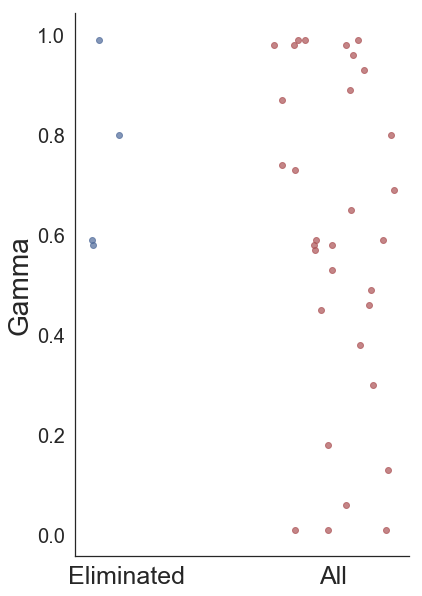

In [65]:
ttestsPlot(params_like_eliminated.gamma,params_part_like.gamma,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "Eliminated", lab2 = "All",title = 'Gamma')


ChoiceSlopes: MeanL = 185.48000000000002; MeanD = 214.2225; [Like - Dislike] =  -28.74249999999998; t =  -0.45 ; p-value =0.6528020430707984


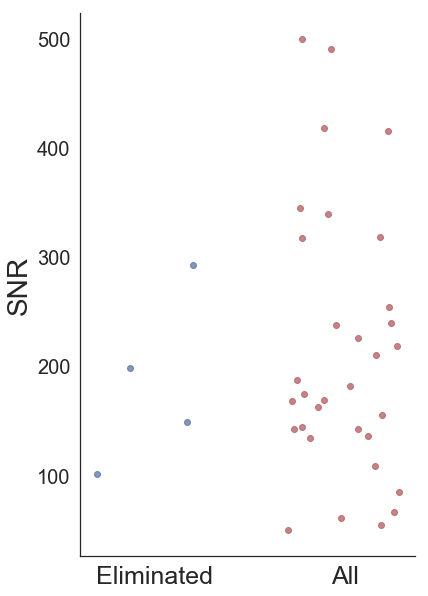

In [66]:
ttestsPlot(params_like_eliminated.SNR,params_part_like.SNR,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "Eliminated", lab2 = "All",title = 'SNR')


ChoiceSlopes: MeanL = 3.35e-05; MeanD = 3.759375000000001e-05; [Like - Dislike] =  -4.093750000000008e-06; t =  -0.44 ; p-value =0.6645770455341571


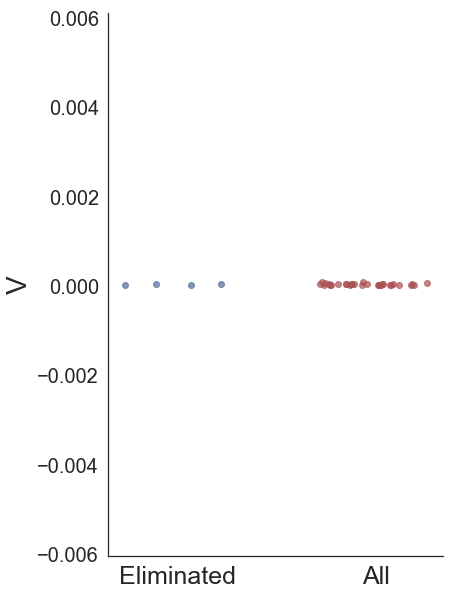

In [67]:
ttestsPlot(params_like_eliminated.v,params_part_like.v,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "Eliminated", lab2 = "All",title = 'V')


ChoiceSlopes: MeanL = 0.007291249999999999; MeanD = 0.007286843749999999; [Like - Dislike] =  4.40625000000007e-06; t =  0.0 ; p-value =0.9968922431168549


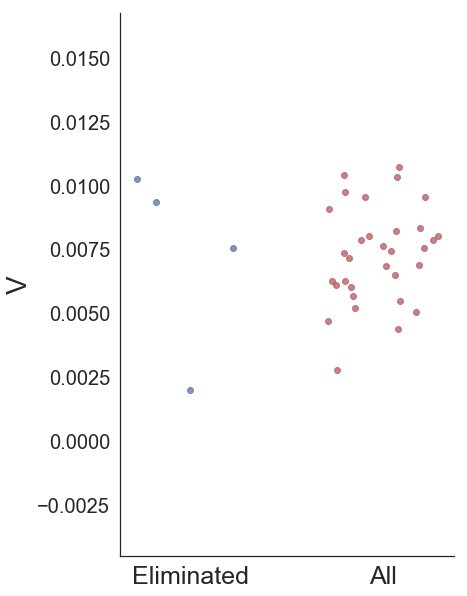

In [71]:
ttestsPlot(params_like_eliminated.s,params_part_like.s,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "Eliminated", lab2 = "All",title = 'V')


## 2. Plot fit

In [ ]:
print('Close Figure to continue...')
glam.plot_fit(test_data, [glam_full.prediction]);
#glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);
glam.plots_pretty.plot_fit(test_data, [glam_full.prediction]);

plt.show()

## [END] 